In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import time
import pickle

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from pgm.data import AlignedSequencesData
from pgm.layers import GaussianLayer, OneHotLayer, DReLULayer
from pgm.edge import Edge
from pgm.model import MRF
from pgm.metrics import aa_acc, l1b_reg, msa_mean, ZeroSumGauge
from pgm.ais import AIS

In [4]:
DATASET = "PF00397"
DATA = "/home/cyril/Documents/These/data"
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY-'

AA_IDS = {l: i for i, l in enumerate(AMINO_ACIDS)}
batch_size = 300
q = 21
N = 31
k = 10
lamb_l1b = 0.25
gamma = lamb_l1b/(2*q*N)
# lamb_l2

## Data

For Proteins

In [5]:
from structure.data_extraction import from_fasta_to_df
from structure.utils import to_onehot

In [6]:
class AlignedSequencesData(object):
    def __init__(self, file):
        self.df = from_fasta_to_df(file)
        self.df["name"] = self.df.index
        self.df[self.df.name.apply(lambda x : x[0]) == "a"]
        self.raw_sequences = np.array(list(self.df.aligned_seq.apply(lambda s: np.array([AA_IDS[c] if c in AA_IDS.keys() else -1 for c in s]))))
        self.raw_sequences = self.raw_sequences[:, ((self.raw_sequences == -1).max(0) == False)] 
        self.size = self.raw_sequences.shape[1]
        self.raw_sequences = [to_onehot(seq, (self.size, len(AA_IDS))) for seq in self.raw_sequences]
        self.weights = np.ones(len(self.df.values))
        
    def __len__(self):
        return len(self.raw_sequences)
    
    def __getitem__(self, i):
        return self.raw_sequences[i], self.weights[i]

In [7]:
filename = "aligned.fasta"
train_dataset = AlignedSequencesData(f"{DATA}/{DATASET}/{filename}")
train_loader = DataLoader(train_dataset, batch_size = batch_size, 
                          shuffle = True, drop_last=True)

# val_dataset = AlignedSequencesData(f"{DATA}/rbm/val.csv")
# val_loader = DataLoader(val_dataset, batch_size = batch_size, 
#                         shuffle = True, drop_last=True)

In [8]:
pots = np.zeros((31, 21))
for w, v in zip(train_dataset.weights,train_dataset.raw_sequences):
    pots += w*v
pots /= np.sum(train_dataset.weights)
pots = pots.T
p0 = F.softmax(torch.log(torch.FloatTensor(pots)),0)

pots = torch.FloatTensor((pots.T-np.mean(pots, 1)).T).view(-1)

## Build Model

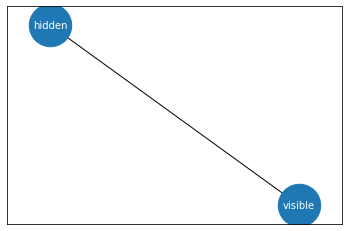

MRF(
  (layers): ModuleDict(
    (hidden): GaussianLayer()
    (visible): OneHotLayer(
      (linear): Linear(in_features=651, out_features=1, bias=True)
    )
  )
  (edges): ModuleDict(
    (visible -> hidden): Edge(
      (in_layer): OneHotLayer(
        (linear): Linear(in_features=651, out_features=1, bias=True)
      )
      (out_layer): GaussianLayer()
      (linear): Linear(in_features=651, out_features=100, bias=False)
      (reverse): Linear(in_features=100, out_features=651, bias=False)
      (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)

In [9]:
device = torch.device('cpu')

visible = OneHotLayer(pots, N = 31, q = 21, name = "visible").to(device)
hidden = GaussianLayer(N = 100, name = "hidden").to(device)

E = [(visible.name, hidden.name)]

model = MRF(layers = {visible.name: visible, 
                    hidden.name: hidden},
         edges = E).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
model

In [10]:
import math

import torch
from torch.distributions.one_hot_categorical import OneHotCategorical

class AIS():

    def __init__(self, model, p_0):
        super(AIS, self).__init__()
        self.q, self.N = p_0.size()
        self.p_0 = p_0.view(-1)
        self.log_p_0 = torch.log(self.p_0+1e-8)
        edge = model.get_edge("visible", "hidden")
        self.gammaI = lambda x: model.layers["hidden"].gamma(edge(x))
        self.W = model.layers["visible"].linear.weights.view(-1)
        self.distribution = OneHotCategorical(p_0.t())

    def update(self, model):
        edge = model.get_edge("visible","hidden")
        self.gammaI = lambda x : model.layers["hidden"].gamma(edge(x))
        self.W = model.layers["visible"].linear.weights.view(-1)

    def run(self, n_samples, n_inter, verbose=0):
        betas = torch.linspace(0, 1, n_inter)
        samples = self._sample(n_samples)
        logp0 = self.log_f0(samples)
#         weights = torch.zeros(n_samples)
        for i, beta in enumerate(betas[1:]):
            samples = self.T(samples, lambda x: self.log_fj(x, beta), n_steps=10)
#             weights += log_fj(samples, beta) - log_fj(samples, last_beta)
            logpn = self.log_fj(samples, beta)
            if verbose and not i%100:
                print(f"Iteration {i}")
        logpn = self.log_fn(samples)
        Z = ((logpn - logp0 - math.log(n_samples)).logsumexp(0))/self.N
        print(f"Estimated Z : {Z:.3f}")
        return Z

    def _sample(self, n_samples):
        return self.distribution.sample((n_samples,)).permute(0,2,1).reshape(n_samples, -1)

    def log_f0(self, x):
        return (self.log_p_0*x).sum(-1)

    def log_fn(self, x):
        ll = (x * self.W).sum(-1)
        ll += self.gammaI(x)
        return ll.detach()

    def log_fj(self, x, beta):
        return self.log_f0(x) * beta + self.log_fn(x)*(1-beta)

    def probs(self, x):
        return (self.p_0.view(1,-1)*x).view(-1,self.q,self.N).permute(0,2,1)

    def T(self, x, f, n_steps = 10):
        n_samples = x.size(0)
        for t in range(n_steps):
            x_prime = OneHotCategorical(self.probs(x)).sample().permute(0,2,1).reshape(n_samples, -1)
            a = f(x_prime) - f(x)
            idx = torch.where(torch.rand_like(a) < torch.exp(a))[0]
            x[idx] = x_prime[idx]
        return x


In [24]:
ll

tensor(17.0079, grad_fn=<DivBackward0>)

In [13]:
start = time.time()
model.train()
in_lays, out_lays = ["visible"], ["hidden"]
edge = model.get_edge("visible", "hidden")
edge.gauge = edge.gauge.to(device)
ais = AIS(model, p0)
mean_loss, mean_reg, mean_acc = 0, 0, 0
Z = 0
for epoch in range(6000):
        # Z estimation
    m, s = int(time.time()-start)//60, int(time.time()-start)%60
    if not epoch%100:
        ais.update(model)
        Z = ais.run(20, 1000)
        print(f'''Train Epoch: {epoch} [100%] || Time: {m} min {s} || Loss: {mean_loss-Z:.3f} || Reg: {mean_reg:.3f} || Acc: {mean_acc:.3f}''', end="\t")
        print()

    mean_loss, mean_reg, mean_acc = 0, 0, 0
    for batch_idx, data in enumerate(train_loader):
        x = data[0].float().permute(0, 2, 1).to(device)
        w = data[1].float().to(device)
        
        # Sampling
        d_0 = {"visible":x}
        d_0, d_f = model.gibbs_sampling(d_0, in_lays, out_lays, k = 10)
        
        # Optimization
        optimizer.zero_grad()
        e_0, e_f = model(d_0), model(d_f)
        reg = l1b_reg(edge)
        loss = msa_mean(e_f-e_0, w) + gamma * reg
        loss.backward()
        optimizer.step()
        
        
        # Metrics
        d_0, d_f = model.gibbs_sampling(d_0, in_lays, out_lays, k = 1)
        acc = aa_acc(d_0["visible"].view(*x.size()), d_f["visible"].view(*x.size()))
        ll = msa_mean(model.integrate_likelihood(d_f, "hidden"),w)/31
        mean_loss = (mean_loss*batch_idx + ll.item())/ (batch_idx+1)
        mean_reg = (mean_reg*batch_idx + gamma*reg)/(batch_idx+1)
        mean_acc = (mean_acc*batch_idx + acc)/(batch_idx+1)
        m, s = int(time.time()-start)//60, int(time.time()-start)%60

    print(f'''Train Epoch: {epoch} [100%] || Time: {m} min {s} || Loss: {mean_loss-Z:.3f} || Reg: {mean_reg:.3f} || Acc: {mean_acc:.3f}''', end="\r")
#     if not epoch % 50:
#         data = next(iter(val_loader))
#         x = data[0].float().permute(0, 2, 1).to(device)
#         x_f, _, mut, _ = edge.gibbs_step(x, sample=False)
#         acc = aa_acc(x, mut.view(batch_size, q, N))
#         m, s = int(time.time()-start)//60, int(time.time()-start)%60
#         print(f'''Val: {epoch} || Time: {m} min {s} || Loss: {mean_loss:.2f} || Reg: {mean_reg:.2f} || Acc: {mean_acc:.2f} ||  Val Acc : {acc:.3f}''')

Estimated Z : 4.255
Train Epoch: 0 [100%] || Time: 0 min 0 || Loss: -4.255 || Reg: 0.000 || Acc: 0.000	
Estimated Z : 6.4090%] || Time: 4 min 40 || Loss: 1.069 || Reg: 4.671 || Acc: 0.6870
Train Epoch: 100 [100%] || Time: 4 min 40 || Loss: -1.085 || Reg: 4.671 || Acc: 0.687	
Estimated Z : 6.59900%] || Time: 9 min 29 || Loss: -0.246 || Reg: 4.693 || Acc: 0.698
Train Epoch: 200 [100%] || Time: 9 min 29 || Loss: -0.436 || Reg: 4.693 || Acc: 0.698	
Estimated Z : 6.18600%] || Time: 14 min 49 || Loss: 0.400 || Reg: 4.673 || Acc: 0.7032
Train Epoch: 300 [100%] || Time: 14 min 49 || Loss: 0.814 || Reg: 4.673 || Acc: 0.703	
Estimated Z : 6.63300%] || Time: 19 min 56 || Loss: 1.624 || Reg: 4.657 || Acc: 0.707
Train Epoch: 400 [100%] || Time: 19 min 56 || Loss: 1.176 || Reg: 4.657 || Acc: 0.707	
Estimated Z : 6.62400%] || Time: 24 min 58 || Loss: 1.982 || Reg: 4.687 || Acc: 0.710
Train Epoch: 500 [100%] || Time: 24 min 58 || Loss: 1.992 || Reg: 4.687 || Acc: 0.710	
Estimated Z : 6.49900%] || Time

KeyboardInterrupt: 

In [24]:
from torch.distributions.one_hot_categorical import OneHotCategorical
import math

In [169]:
ais_ = AIS(model, q)

In [215]:
ais_.update(model)

In [21]:
class AIS(object):
    def __init__(self, model, p_0):
        super(AIS, self).__init__()
        self.q, self.N = p_0.size()
        self.p_0 = p_0.view(-1)
        self.log_p_0 = torch.log(self.p_0+1e-8)
        self.edge = model.get_edge("visible", "hidden")
        self.gammaI = lambda x: model.layers["hidden"].gamma(self.edge(x))
        self.W = model.layers["visible"].linear.weights.view(-1)
        self.distribution = OneHotCategorical(p_0.t())
    
    def update(self, model):
        edge = model.get_edge("visible","hidden")
        self.gammaI = lambda x : model.layers["hidden"].gamma(edge(x))
        self.W = model.layers["visible"].linear.weights.view(-1)

    def run(self, n_samples, n_inter, verbose = 0):
        betas = torch.linspace(0, 1, n_inter)
        samples = self._sample(n_samples)
        logp0 = self.log_f0(samples)
        weights, last_beta = torch.zeros(n_samples), 0
        for i, beta in enumerate(betas[1:]):
            samples = self.T(samples, lambda x: self.log_fj(x, beta), n_steps=10)
            weights += self.log_fj(samples, beta) - self.log_fj(samples, last_beta)
            logpn = self.log_fj(samples, beta)
            if verbose and not i%100:
                print(f"Iteration {i}")
            last_beta = beta
        logpn = self.log_fn(samples)
        Z = ((logpn - logp0 + F.log_softmax(weights)).logsumexp(0))/self.N
        print(f"Estimated Z : {Z:.3f}")
        return Z

    def _sample(self, n_samples):
        return self.distribution.sample((n_samples,)).permute(0,2,1).reshape(n_samples, -1)

    def log_f0(self, x):
        return (self.log_p_0*x).sum(-1)

    def log_fn(self, x):
        ll = (x * self.W).sum(-1)
        ll += self.gammaI(x)
        return ll.detach()

    def log_fj(self, x, beta):
        return self.log_f0(x) * beta + self.log_fn(x)*(1-beta)

    def probs(self, x):
        return (self.p_0.view(1,-1)*x).view(-1,self.q,self.N).permute(0,2,1)
    
    def T(self, x, f, n_steps = 10):
        n_samples = x.size(0)
        all_a = torch.zeros(1)
        for t in range(n_steps):
            x_prime = x
            M, m = x_prime.max(1)[0].view(n_samples, 1, -1), x_prime.min(1)[0].view(n_samples, 1, -1)
            x_prime = ((x_prime - m)/(M-m)).view(n_samples, -1)
            a = f(x_prime) - f(x)
            idx = torch.where(torch.rand_like(a) < torch.exp(a))[0]
            x[idx] = x_prime[idx]
        return x

In [51]:
logp0, logpn

(tensor([-38.2584, -56.7578, -52.0028, -42.9196, -51.8066, -50.1381, -49.0375,
         -48.3241, -51.0302, -43.0765, -44.5343, -52.8494, -52.1525, -47.2793,
         -42.3857, -56.0578, -50.5654, -54.1937, -47.7897, -58.7446]),
 tensor([71.7383, 90.3591, 79.6855, 71.9978, 78.3271, 72.8988, 65.9444, 79.8431,
         45.2522, 89.2900, 72.4411, 84.5131, 72.0197, 80.9908, 71.5175, 65.5092,
         93.0296, 80.9757, 74.9391, 75.3499]))

In [78]:
torch.max(x, torch.ones(x.size()))

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1., 

In [90]:
ais_ = AIS(model, p0)

In [92]:
Z = ais_.run(20, 1000)

Estimated Z : 5.068


In [117]:
F.log_softmax(weights), logpn - logp0

(tensor([-1010.0593,  -453.6169,   -75.5941,   -30.1659,  -732.1194,  -578.5587,
          -543.8281,  -537.0428,  -178.9714,  -680.0652,  -679.7471,  -454.3023,
          -590.3973, -1321.6151,     0.0000,  -711.8146,  -535.9572, -1078.3324,
          -508.5076,  -683.5151]),
 tensor([140.9662, 143.1859, 118.0419, 126.4386, 130.2012, 152.7874, 135.1541,
         125.2087, 118.6375, 160.1119, 140.6018, 127.2794, 133.7686, 150.9615,
         141.5560, 112.0823, 112.8044, 146.1756, 125.4359, 148.1181]))

In [119]:
Z = 141.5560/31

In [111]:
Z = ((logpn - logp0).logsumexp(0) - math.log(20))/31
Z

tensor(5.0683)

## Visualize

In [11]:
import sys

ROOT = "/home/cyril/Documents/These"
sys.path.append(f"{ROOT}/paper_codes/PGM3/source/")
sys.path.append(f"{ROOT}/paper_codes/PGM3/utilities/")

import Proteins_utils, RBM_utils, utilities10 as utilities, sequence_logo, plots_utils

def get_beta(W,include_gaps=False):
    if not include_gaps:
        W_ = W[:,:,:-1]
    else:
        W_ = W
    return  np.sqrt( (W_**2).sum(-1).sum(-1) ).numpy()

/home/cyril/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../paper_codes/PGM3/source/numba_utilities10.py", line 391:
@njit(signature0,parallel=True)
def erf_times_gauss_numba0(x):
^

  state.func_ir.loc))
/home/cyril/Documents/These/paper_codes/PGM3/source/numba_utilities10.py:849: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights,V)/sum_weights
/home/cyril/Documents/These/paper_codes/PGM3/source/numba_utilities10.py:995: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T,V)
/home/cyril/Docume

In [12]:
max_acti = model.get_edge("visible", "hidden").get_weights().detach().view(-1, 21, 31).permute(0,2,1)
order = np.argsort(get_beta(max_acti))[::-1]

/home/cyril/Documents/These/paper_codes/PGM3/utilities/sequence_logo.py:519: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


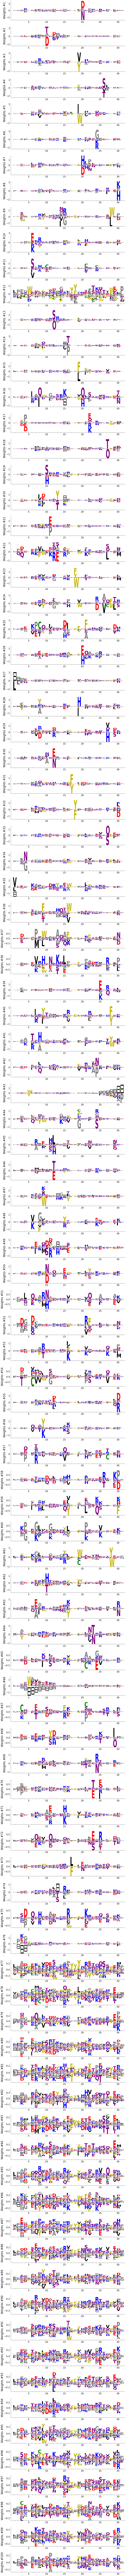

In [13]:
fig = sequence_logo.Sequence_logo_multiple(max_acti.numpy()[order], figsize=(15,3) ,ticks_every=5,ticks_labels_size=20,title_size=24);